가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 사용

# 라이브러리 불러오기

In [41]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 데이터 불러오기

In [2]:
df_org = pd.read_csv('./data/house_price.csv')

df = df_org.copy()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 데이터 세트의 전체 크기와 칼럼의 타입, null 컬럼과 건수 확인

print('데이터 세트의 크기 : ', df.shape)
print('\n전체 피처의 type\n', df.dtypes.value_counts())

isnull_series = df.isnull().sum()
print('\nNull 칼럼과 그 건수 : \n', isnull_series[isnull_series > 0].sort_values(ascending = False)) # null값이 있는 col명과 그 수를 내림차순으로 정렬

데이터 세트의 크기 :  (1460, 81)

전체 피처의 type
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


=> null값이 너무 많은 피처는 삭제한다

# 데이터 사전 처리

회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인

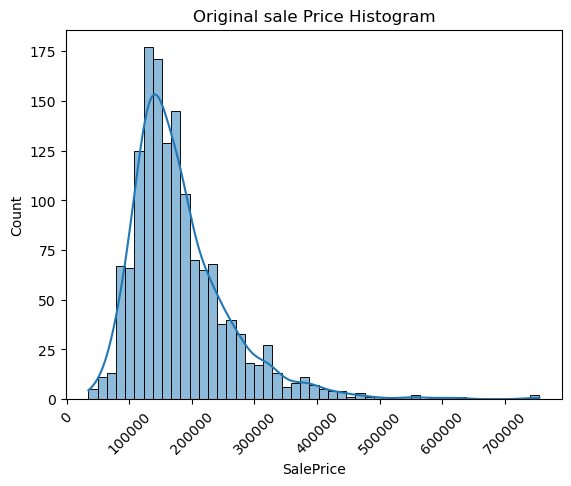

In [4]:
plt.title('Original sale Price Histogram')
plt.xticks(rotation = 45);
sns.histplot(df['SalePrice'], kde = True);

=> 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로 정규분포에서 벗어나 있다

=> 정규 분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환을 적용

    -> 로그 변환 값을 기반으로 학습 한 후 예측 시에는 다시 지수 변환을 해야 한다

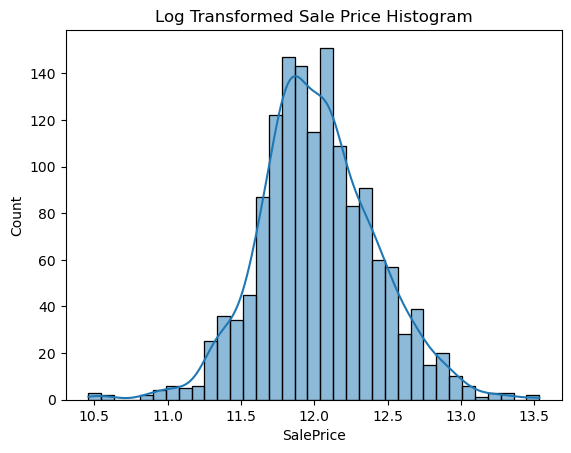

In [5]:
# 로그 변환 후 다시 그래프 그리기

plt.title('Log Transformed Sale Price Histogram')
log_saleprice = np.log1p(df['SalePrice'])
sns.histplot(log_saleprice, kde = True);

- 타깃값을 로그 변환하기

- null값이 많은 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'는 삭제

- 'Id'는 단순 식별자이므로 삭제

- 'LotFrontage'는 null 값이 259로 비교적 많으나 평균값으로 대치

- 나머지 null 피처는 null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체

In [6]:
# 'SalePreice' 로그 변환
df['SalePrice'] = np.log1p(df['SalePrice'])

# null값이 너무 많은 컬럼과 불필요한 컬럼 삭제
df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)

# 드롭하지 않는 숫자형 null 컬럼은 평균값으로 대체
# 숫자형 타입을 가진 col 가져오기
num_col = df.select_dtypes(include = ['int', 'float']).columns
df[num_col] = df[num_col].fillna(df[num_col].mean())

# null값이 있는 피처명과 타입을 추출
null_col_cnt = df.isnull().sum()[df.isnull().sum() > 0]
print(' ## Null 피처의 Type : \n', df.dtypes[null_col_cnt.index])

 ## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


=> 이제 문자형 피쳐를 제외하고는 null값이 없다

=> 문자형 피쳐는 One-Hot-Encoding으로 변환

In [7]:
print('get_dummies() 수행 전 데이터 shape : ', df.shape)

df_ohe = pd.get_dummies(df)
print('get_dummies() 수행 후 데이터  shape : ', df_ohe.shape)

null_col_cnt = df_ohe.isnull().sum()[df_ohe.isnull().sum() > 0]
print('### Null 피처의 type : \n', df_ohe.dtypes[null_col_cnt.index])

get_dummies() 수행 전 데이터 shape :  (1460, 75)
get_dummies() 수행 후 데이터  shape :  (1460, 270)
### Null 피처의 type : 
 Series([], dtype: object)


# 선형 회귀 모델 학습/평가/예측

## 평가 함수

- 이미 타깃 값인 'SalePrice'가 로그 변환

- 예측 값 역시 로그 변환된 'SalePrice' 값을 기반으로 예측하므로 원본 'SelePrice' 예측값의 로그 변환 값이다

- 실제 값도 로그 변환됐고, 예측값도 이를 반영한 로그 변환 값이므로 예측 결과 오류에 RMSE만 적용하면 자동으로 RMSLE가 자동으로 측정된다

In [8]:
# 여러 모델의 로그 변환된 RMSE를 측정하는 함수 생성

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE : ', np.round(rmse, 3))
    
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

=> get_rmse()는 단일 모델의 RMSE값을, get_rmses()는 get_rmse()를 이용해 여러 모델의 RMSE 값을 반환

## 방법 1

### 데이터 나누기(train_test_split)

In [9]:
y_target = df_ohe['SalePrice'] # df_ohe : One-Hot-Encoding을 진행한 dataframe
X_features = df_ohe.drop(['SalePrice'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

### 모델 생성/학습/평가/예측

In [10]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가

lr = LinearRegression() # 모델 생성
lr.fit(X_train, y_train) # 학습

ridge = Ridge() # 모델 생성
ridge.fit(X_train, y_train) # 학습

lasso = Lasso() # 모델 생성
lasso.fit(X_train, y_train) # 학습

models = [lr, ridge, lasso]
get_rmses(models) # 평가

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.127
Lasso 로그 변환된 RMSE :  0.176


[0.13183184688250485, 0.12740582836266195, 0.17628250556471395]

=> lasso 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나왔다

=> lasso의 경우 최적 하이퍼 파라미터 튜닝이 필요해 보인다

<br>
<br>
먼저 피처별 회귀 계수를 시각화하여 모델별 어떤 피처의 회귀 계수로 구성되는지 확인

피처가 많아 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체를 반환하는 함수 생성

In [11]:
def get_top_bottom_coef(model, n = 10):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index = X_features.columns)
    
    # 상위 10개, 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending = False).head(n)
    coef_low = coef.sort_values(ascending = False).tail(n)
    return coef_high, coef_low

생성한 get_top_bottom_coef() 함수를 이용해 모델별 회귀 계수를 시각화

시각화를 위한 함수로 visualize_coefficient()를 생성

    -> list 객체로 모델을 입력받아 모델별로 회귀 계수 상위 10개, 하위 10개를 추출해 가로 막대 그래프 형태로 출력

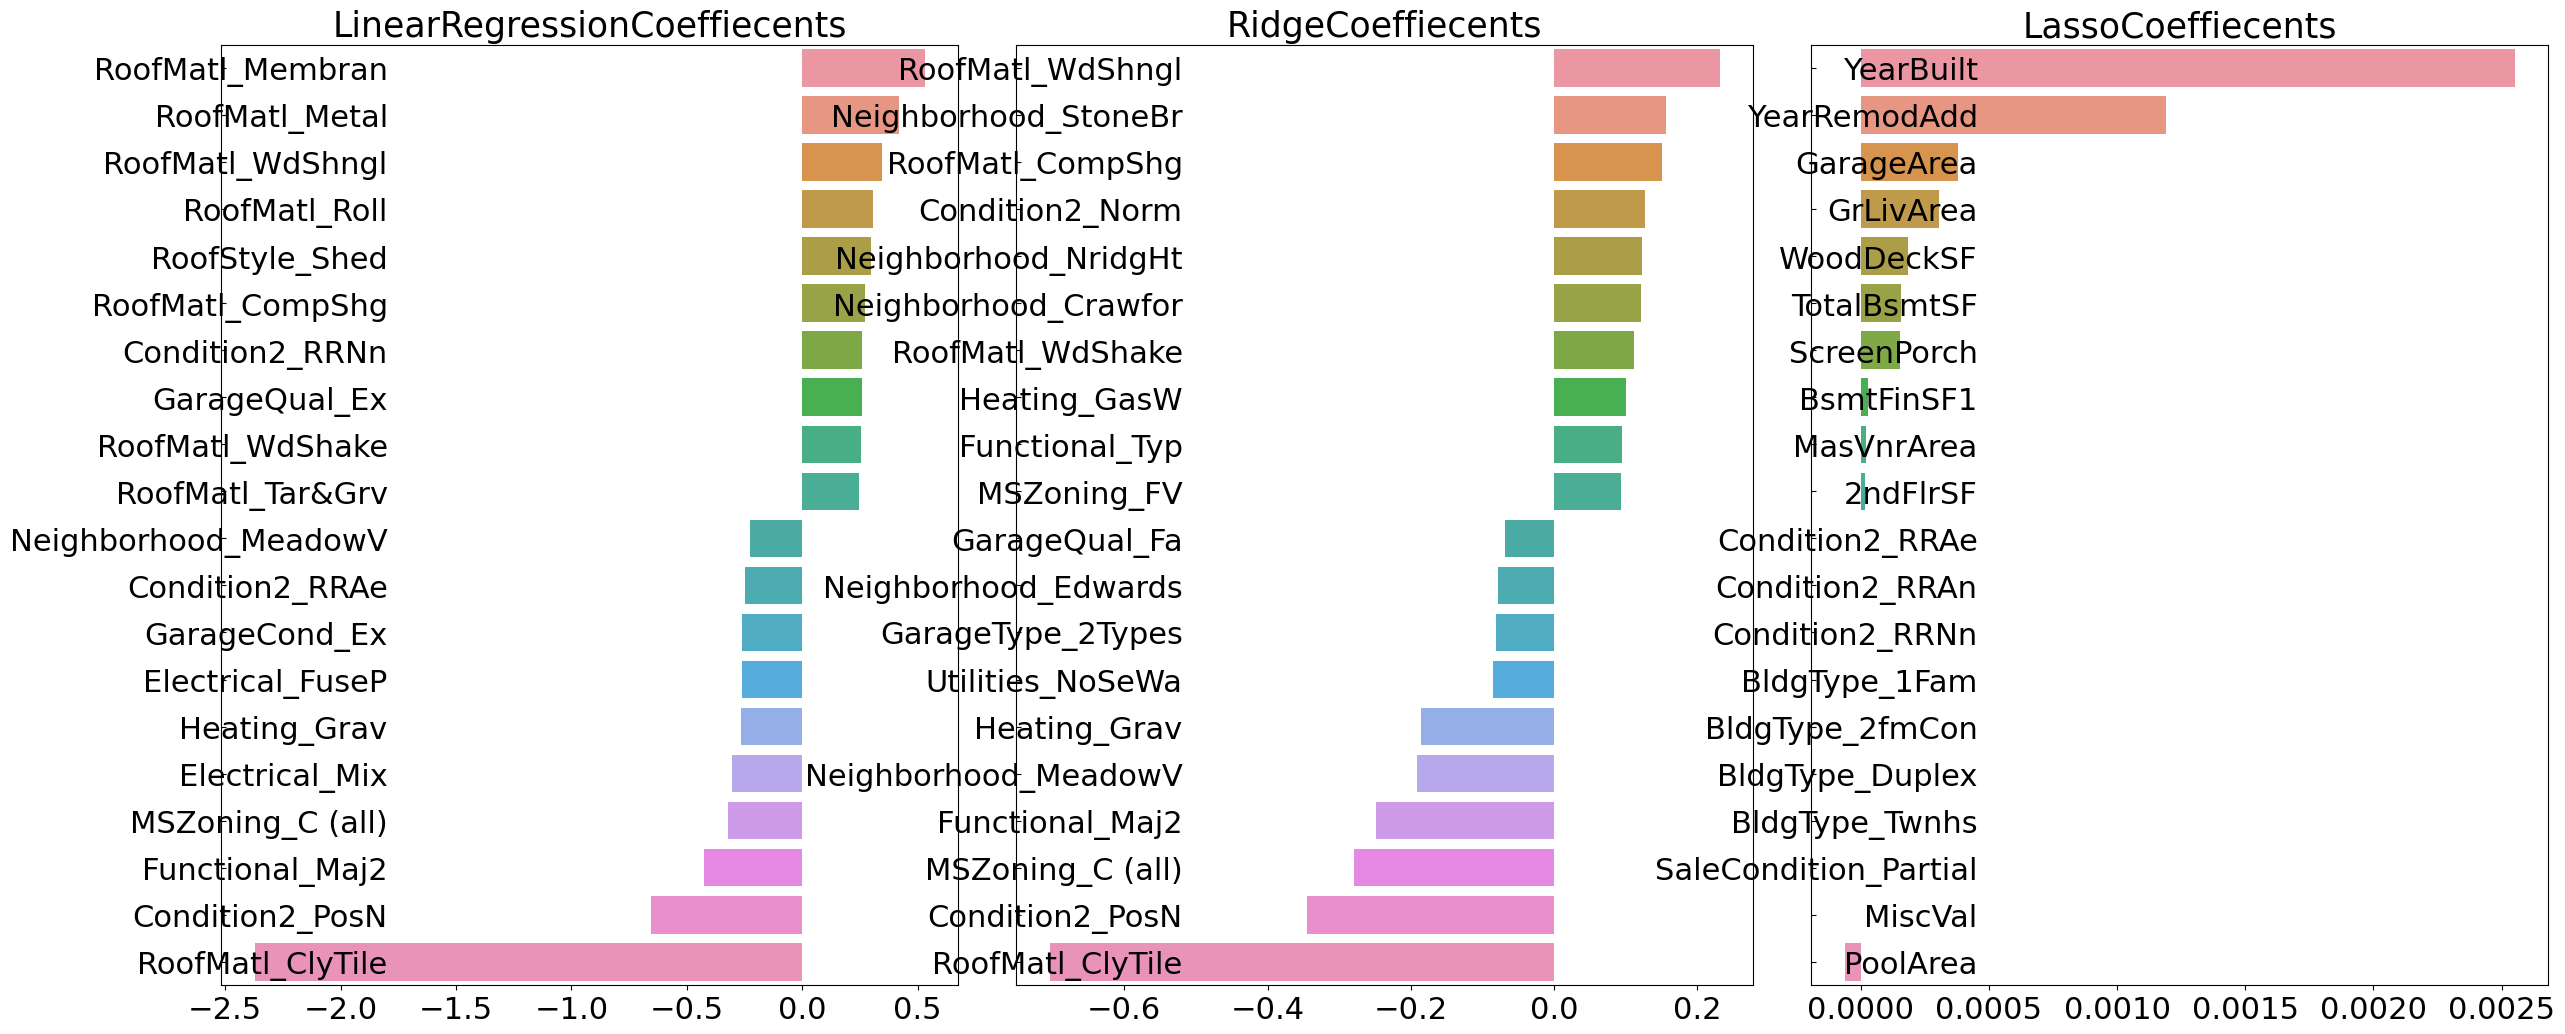

In [12]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols = 3)
    fig.tight_layout() # 그래프의 레이아웃을 조정하여 서로 겹치지 않도록 하는 역할
    
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_df = pd.concat([coef_high, coef_low])
        
        # ax subplot에 batchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiecents', size = 25)
        axs[i_num].tick_params(axis = 'y', direction = 'in', pad = -120) # 축의 눈금에 대한 속성을 설정
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22) # x축과 y축의 눈금 레이블에 대해 폰트 크기를 설정
        sns.barplot(x = coef_df.values, y = coef_df.index, ax = axs[i_num])
        
# 모델의 회귀 계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

=> lasso는 전체적으로 회귀 계수 값이 매우 작고, 그 중에 ''YearBuilt'가 가장 크고 다른 피처의 회귀 계수는 너무 작다

=> 학습과 테스트 데이터 세트를 train_test_split()로 분할하지 않고 교차 검즘 폴드 세트로 분할

## 방법 2

### 데이터 나누기(교차 검증 폴드)

In [13]:
def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score()수행. 모델별 cv RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring = 'neg_mean_squared_error', cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{} cv RMSE 값 리스트 : {}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{} cv 평균 RMSE 값 : {}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))        
        
# 모델의 cv RMSE값 출력
models = [ridge, lasso]
get_avg_rmse_cv(models)


Ridge cv RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge cv 평균 RMSE 값 : 0.144

Lasso cv RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso cv 평균 RMSE 값 : 0.198


=> 5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우 릿지 모델보다 성능이 떨어진다

=> 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출

print_best_params(model, params)는 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수

### 그리드 서치

In [14]:
def print_best_parms(model, parmas):
    grid_model = GridSearchCV(model, param_grid = parmas,
                              scoring = 'neg_mean_squared_error', cv = 5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{} 5 CV 시 최적 평균 RMSE 값 : {}, 최적 alpha : {}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_parms(ridge, ridge_params)
print_best_parms(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


=> 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화

## 최적 모델

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.124
Lasso 로그 변환된 RMSE :  0.12


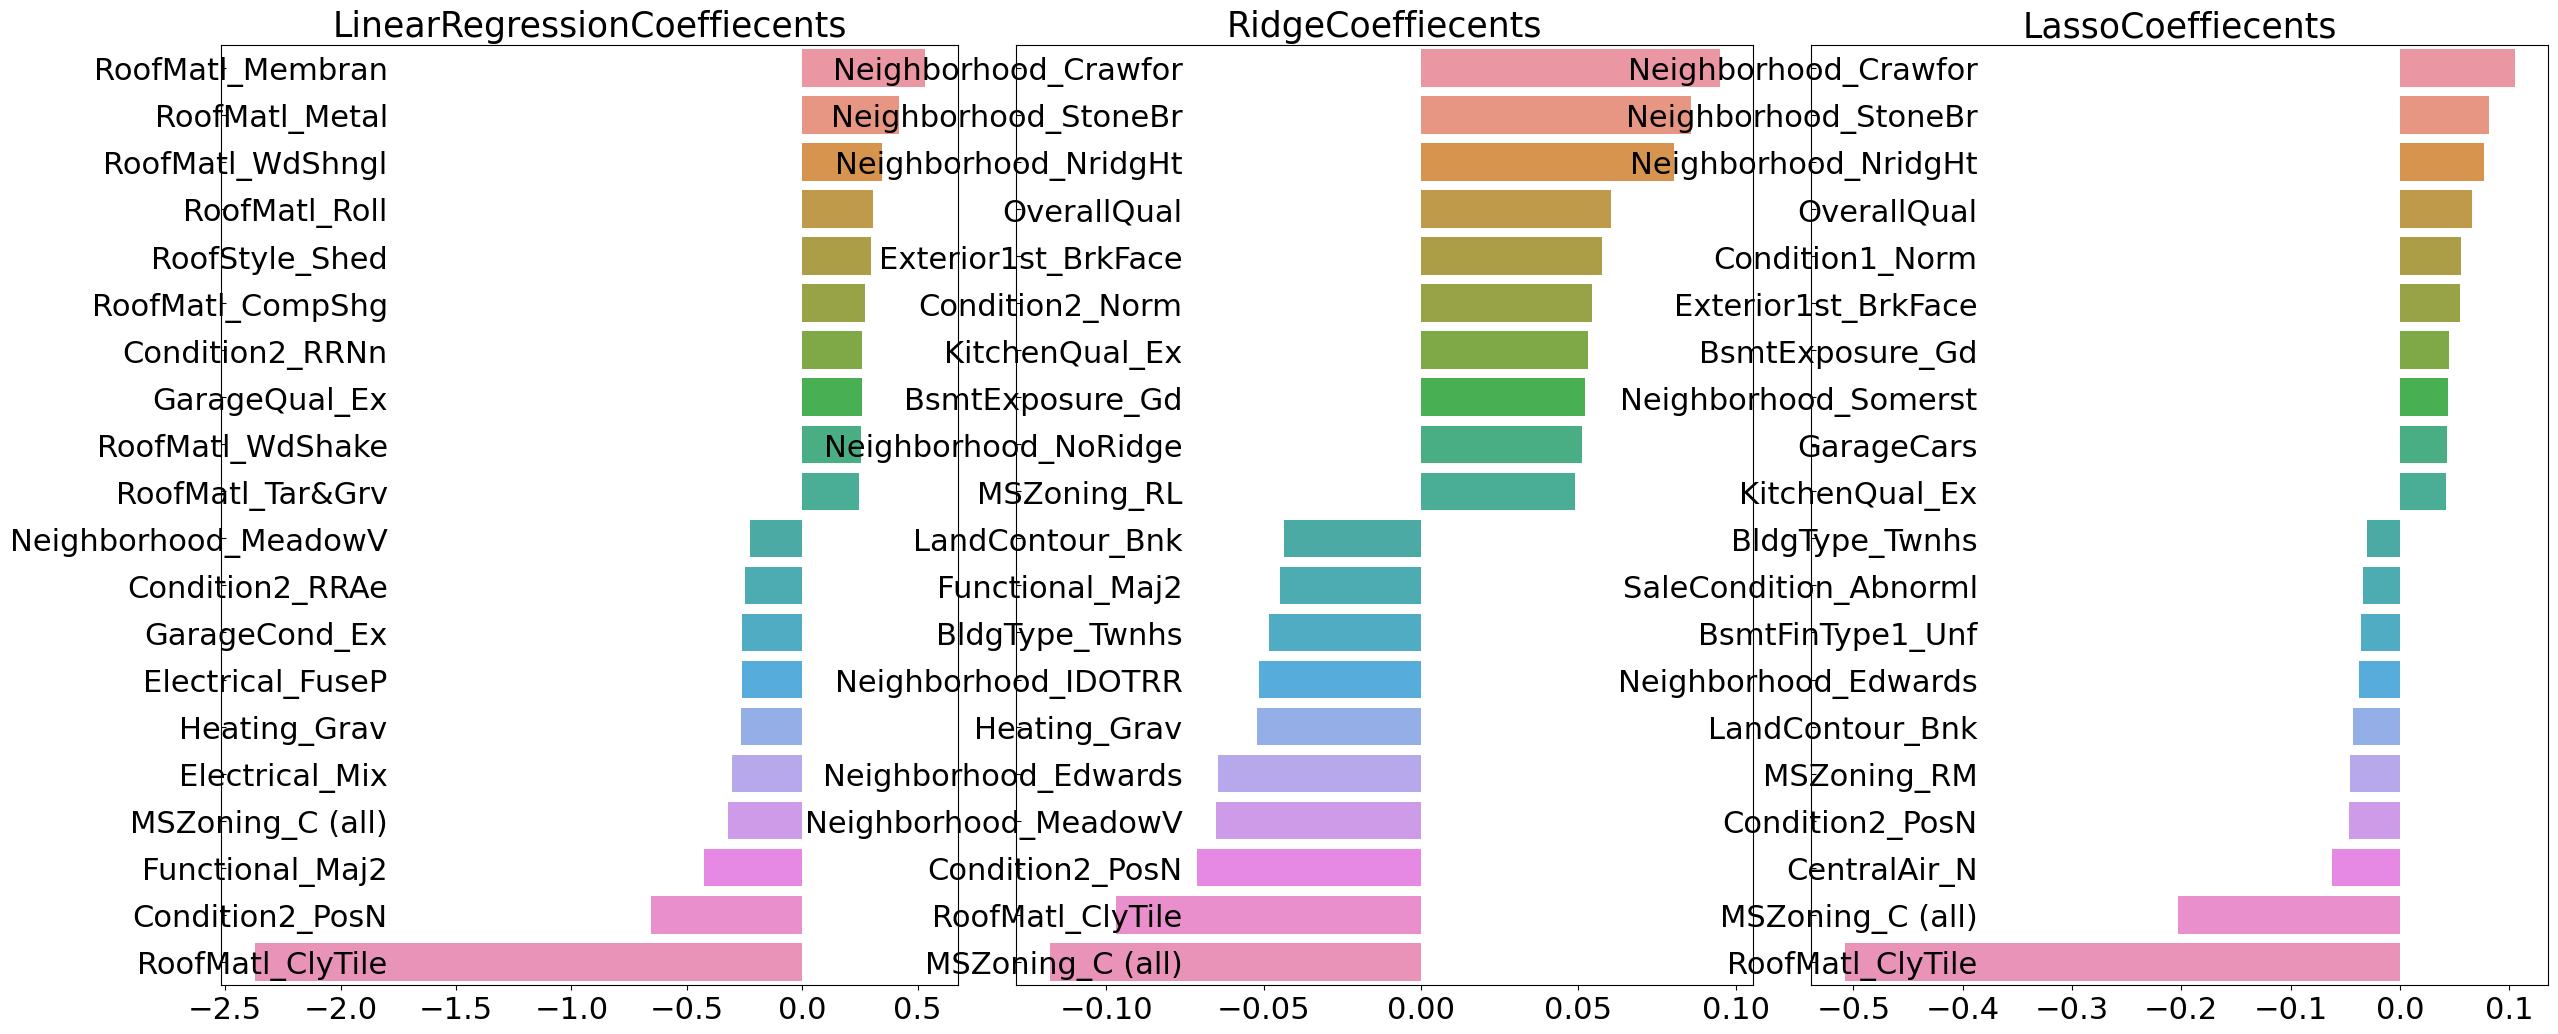

In [15]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행

lr = LinearRegression()
lr.fit(X_train, y_train)

ridge = Ridge(alpha = 12)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr, ridge, lasso]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

=> alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌다

=> 모델별 회귀 계수도 많이 달라졌다

=> lasso 모델의 경우 ridge 모델에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작다

데이터 세트를 추가적으로 가공하여 모델 튜닝을 더 진행

    1. 피처 데이터 세트의 데이터 분포도
    
    2. 이상치 데이터 처리

# 추가 방법

## 피처 데이터 세트의 분포도 확인

피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존대할 경우 회귀 예측 성능을 저하시킬 수 있다

모든 숫자형 피처의 데이터 분포도를 확인해 분포도가 어느 정도로 왜곡됐는지 확인

<br><br>

- 사이파이 stats 모듈의 skew()함수를 이용해 컬럼의 데이터 세트의 왜곡된 정도 확인

- 1이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용

숫자형 피처의 컬럼 index 객체를 추출해 구한 숫자형 컬럼 데이터 세트의 apply lambda 식 skew()를 호출해 숫자형 피처의 왜곡 정도를 구한다

    -> skew()를 적용하는 숫자형 피처에서 One-Hot-Encoding된 카테고리 숫자형 피처는 제외

In [16]:
# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = df.dtypes[df.dtypes != 'object'].index # object 타입이 아닌 데이터의 index 추출

# df에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1 이상인 컬럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


이제 추출된 왜곡 정도가 높은 피처를 로그 변환한다

In [17]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

=> df의 피처 일부를 로그 변환했으므로 다시 One-Hot-Encoding을 적용한 df_ohe 생성

=> 데이터 새트와 타깃 데이터 세트, 학습/테스트 데이터 세트를 모두 다시 생성

=> print_best_params()함수를 이용해 최적 alpha 값과 RMSE 출력

In [18]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 One-Hot-Encoding을 적용하고 피처/타깃 데이터 세트 생성

df_ohe = pd.get_dummies(df)

# 데이터 나누기
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop(['SalePrice'], axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_parms(ridge, ridge_params)
print_best_parms(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


=> 두 모델 모두 피처의 로그 변환 이전과 비교해 5폴드 교차 검증의 평균 RMSE값이 증가

다시 위의 train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 및 모델별 회귀 계수를 시각화

LinearRegression 로그 변환된 RMSE :  0.128
Ridge 로그 변환된 RMSE :  0.122
Lasso 로그 변환된 RMSE :  0.119


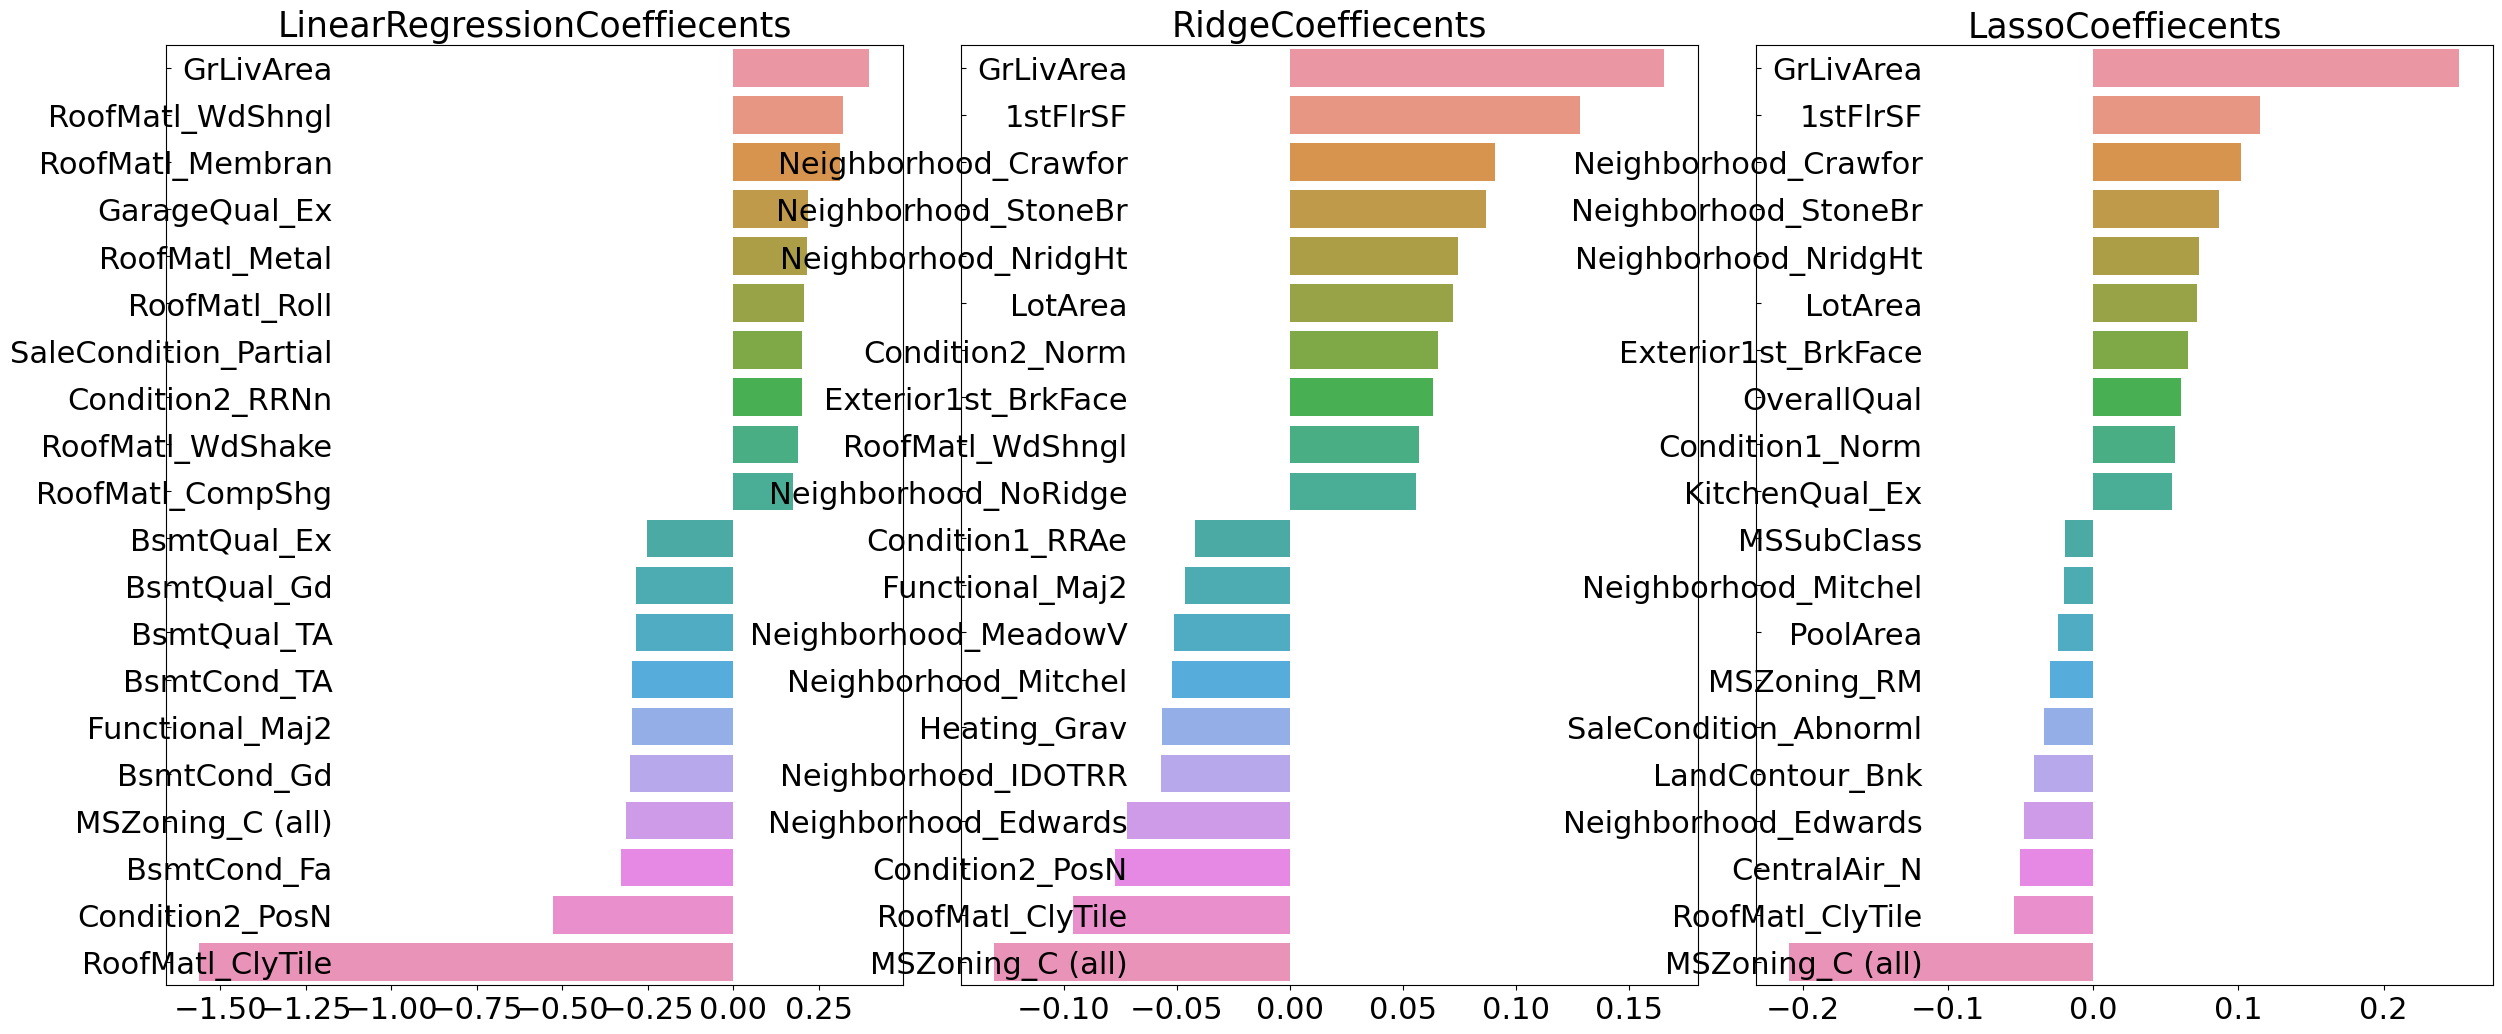

In [19]:
# 모델별 회귀 계수를 시각화

lr = LinearRegression()
lr.fit(X_train, y_train)

ridge = Ridge(alpha = 10)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr, ridge, lasso]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

=> 세 모델 모두 'GrLivArea' 즉, 주거 공간 크기가 회귀 계수가 가장 높은 피처이다

## 이상치 데이터

회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요

먼저 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 'GrLivArea' 피처의 데이터 분포를 살펴보기

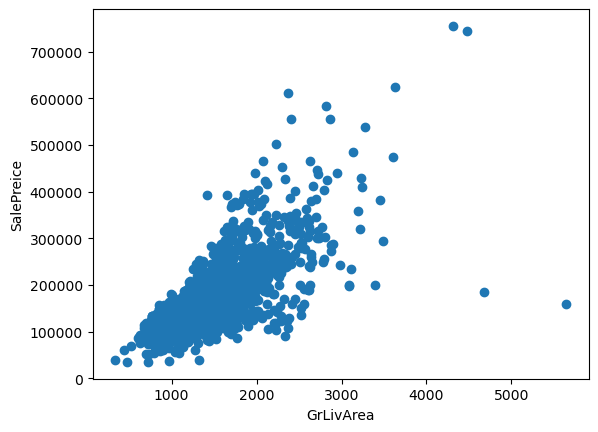

In [20]:
# 데이터가 변환되기 이전의 원본 데이터 세트(df_org)에서 'GrLiArea'와 타깃 값인 'SalePrice'의 관계룰 시각화

plt.scatter(x = df_org['GrLivArea'], y = df_org['SalePrice']);
plt.ylabel('SalePreice');
plt.xlabel('GrLivArea');

=> 오른쪽 아래 데이터 2개는 일반적인 'GrLivArea'와 'SalePrice' 관계에서 너무 어긋나 있다

=> 두 데이터의 'GrLivArea'가 가장 크지만 가격은 매우 낮다

=> 'GrLivArea'가 4000평방비트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제

데이터 변환이 완료된 (df_ohe)에서 대상 데이터를 필터링

In [21]:
# 'GrLivArea'와 'SalePrice' 모두 로그 변환됐으므로 이를 반영항 조건 생성

cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

print('이상치 레코드 index : ', outlier_index.values)
print('이상치 삭제 전 df_ohe의 shape : ', df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
df_ohe.drop(outlier_index, axis = 0, inplace = True)
print('이상치 삭제 후 df_ohe의 shape : ', df_ohe.shape)

이상치 레코드 index :  [ 523 1298]
이상치 삭제 전 df_ohe의 shape :  (1460, 270)
이상치 삭제 후 df_ohe의 shape :  (1458, 270)


=> 업데이트된 df_ohe를 기반으로 피처 데이터 세트와 타킷 데이터 세트를 다시 생성하고 앞에서 정의한 print_best_params()함수를 이용해 릿지와 라쏘 모델의 최적화를 수행하고 결과를 출력

In [22]:
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop(['SalePrice'], axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_parms(ridge, ridge_params)
print_best_parms(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}


=> 단 두 개의 이상치 데이터만 제거했는데 예측 수치가 매우 크게 향상

=> 'GrLivArea' 속성이 회귀 모델에서 차지하는 영향도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가졌다

이상치가 제거된 데이터 세트를 기반으로 다시 train_test_split()로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수를 시각화 한 결과

LinearRegression 로그 변환된 RMSE :  0.129
Ridge 로그 변환된 RMSE :  0.103
Lasso 로그 변환된 RMSE :  0.1


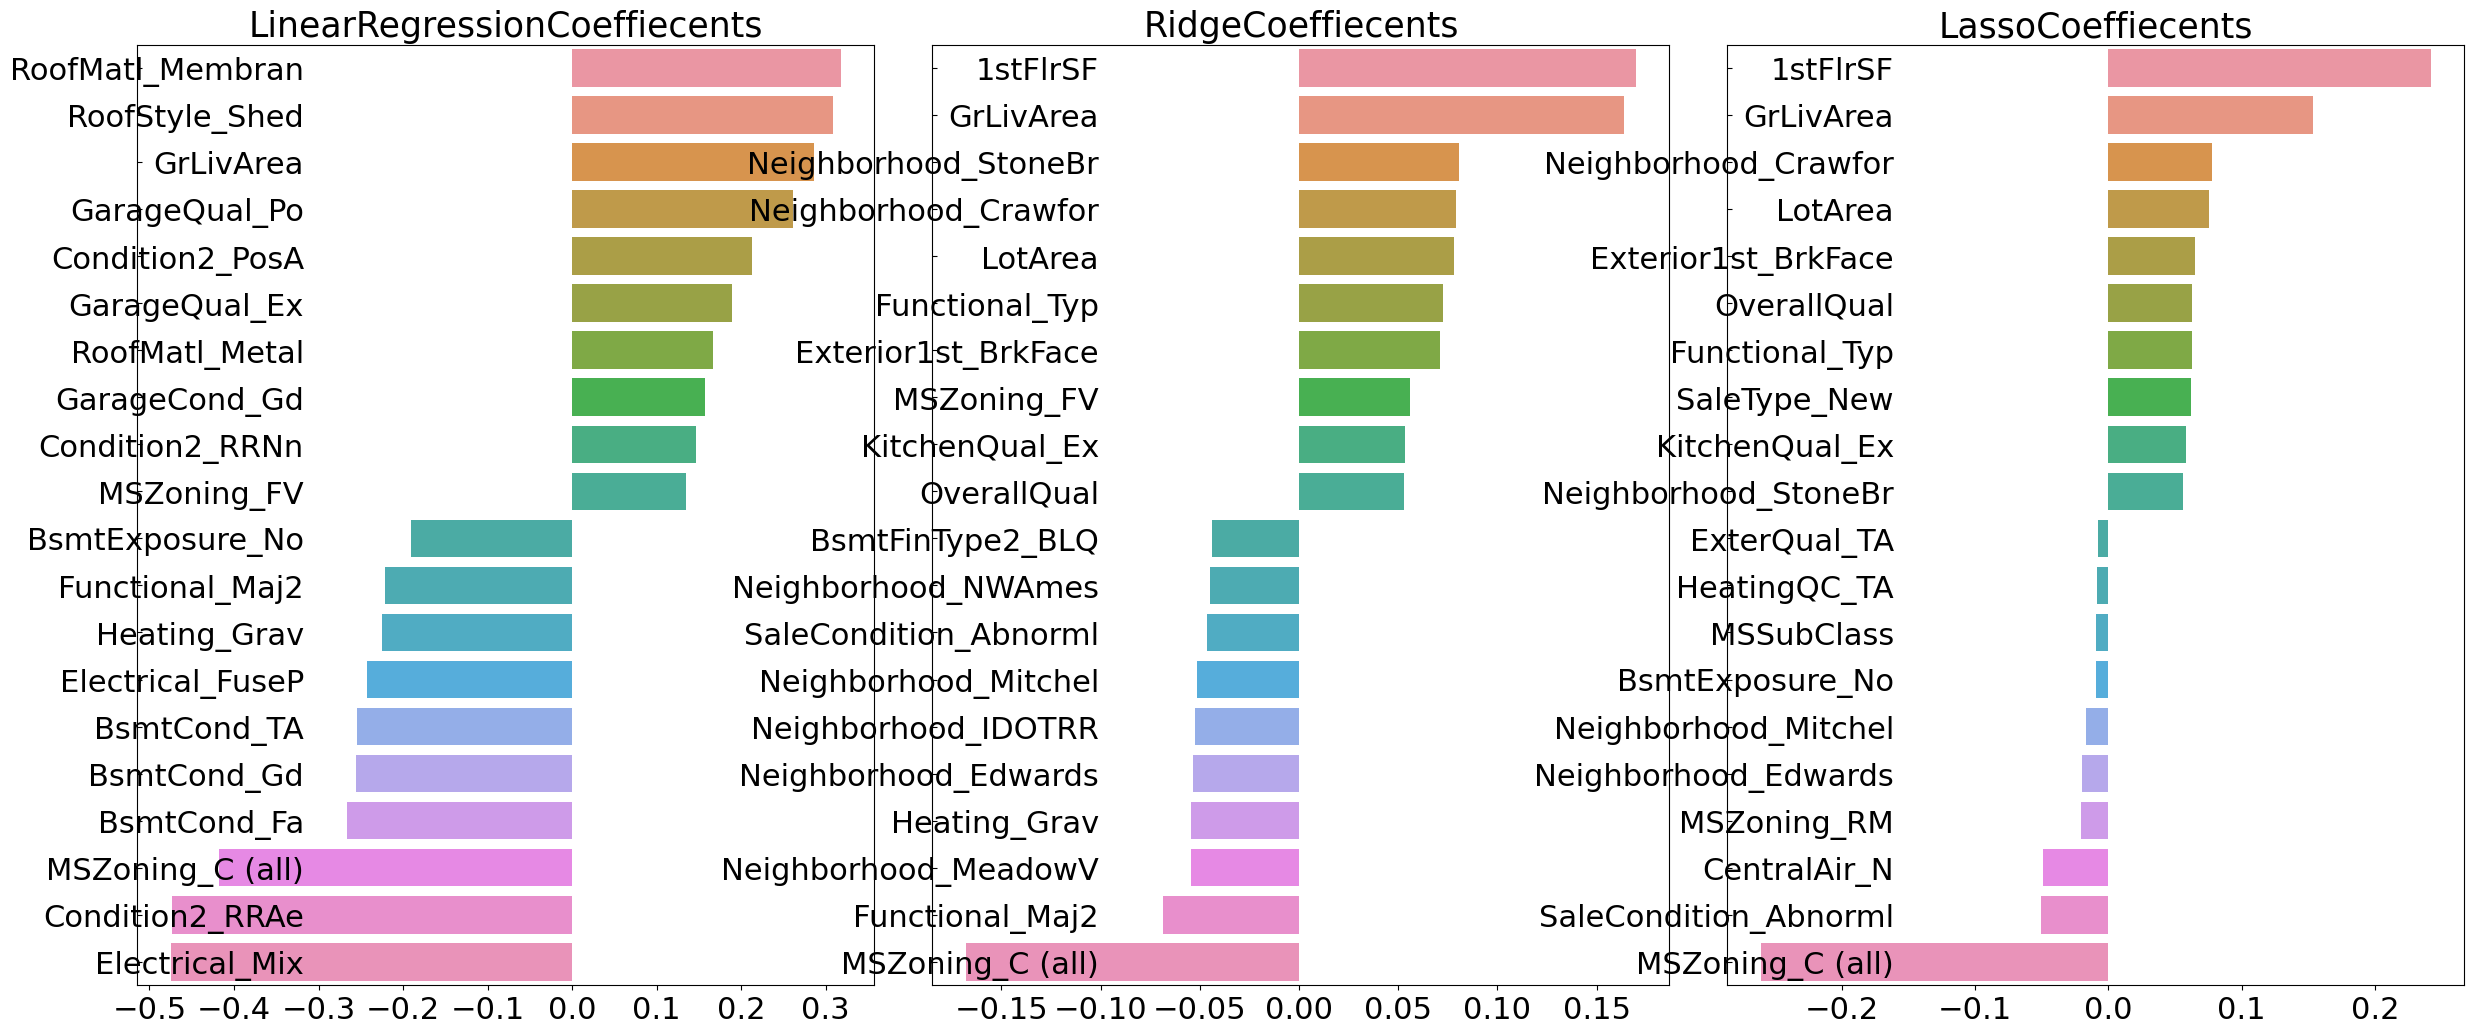

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

ridge = Ridge(alpha = 8)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr, ridge, lasso]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr, ridge, lasso]
visualize_coefficient(models)

# 회귀 트리 모델 학습/예측/평가

xgboost와 lightgbm 모두 수행 시간이 오래 걸릴 수 있는 관계로 하이퍼 파라미터 설정을 미리 적용한 상태로 5폴드 세트에 대한 평균 RMSE 값을 구한다

In [25]:
xgb_params = {'n_estimators' : [1000]}
xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
print_best_parms(xgb, xgb_params) # 그리드 서치

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1184, 최적 alpha : {'n_estimators': 1000}


In [26]:
lgbm_params = {'n_estimators' : [1000]}
lgbm = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, subsample = 0.6, colsample_bytree = 0.4, reg_lambda = 10, n_jobs = -1)
print_best_parms(lgbm, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1179, 최적 alpha : {'n_estimators': 1000}


모델의 피처 중요도를 시각화

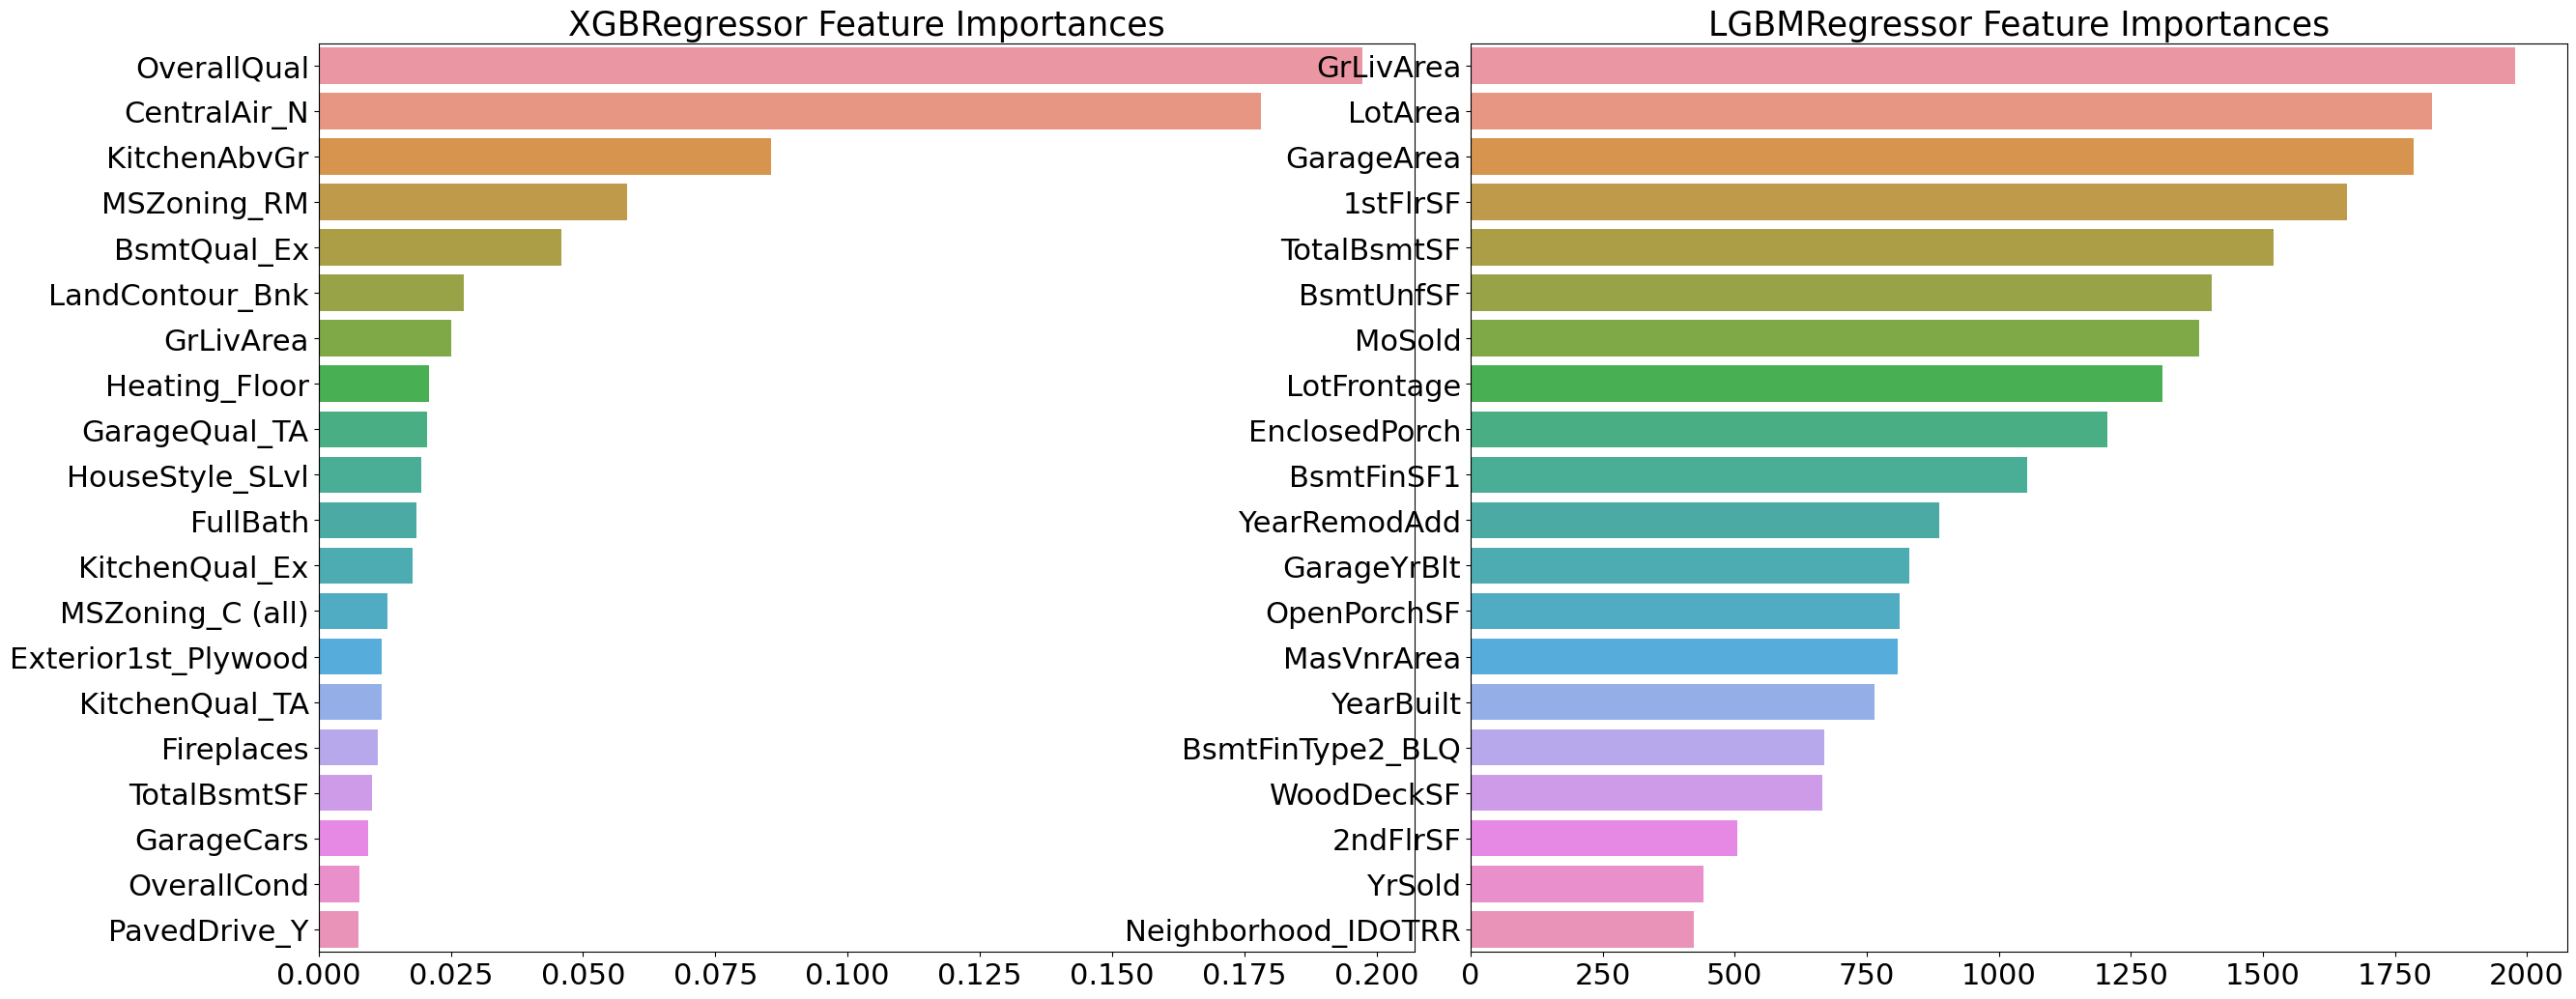

In [33]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])
        

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
xgb = XGBRegressor(n_estimators = 1000)
xgb.fit(X_train, y_train)

lgbm = LGBMRegressor(n_estimators = 1000)
lgbm.fit(X_train, y_train)

models = [xgb, lgbm]
visualize_ftr_importances(models)

# 회귀 모델의 예측 결과 혼합을 통한 최종 예측

개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값을 예측

최종 혼합 모델, 개별 모델의 RMSE값을 출력하는 get_rmse_pred() 함수를 생성하고 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE 구하기

In [36]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_val = preds[key]
        mse = mean_squared_error(y_test, pred_val)
        rmse = np.sqrt(mse)
        
        print('{} 모델의 RMSE : {}'.format(key, rmse))
        
# 개별 모델의 학습
ridge = Ridge(alpha = 8)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합' : pred,
         'Ridge' : ridge_pred,
         'Lasso' : lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10006075517615198
Ridge 모델의 RMSE : 0.10340697165289345
Lasso 모델의 RMSE : 0.10024171179335353


xgb, lgbm을 혼합하여 결과 확인

In [38]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
lgbm = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, subsample = 0.6, colsample_bytree = 0.4, reg_lambda = 10, n_jobs = -1)

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합' : pred,
         'XGBM' : xgb_pred,
         'LGBM' : lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.1014930603755743
XGBM 모델의 RMSE : 0.10608167218368826
LGBM 모델의 RMSE : 0.10363891833477148


# 스태킹 앙상블 모델으을 통한 회귀 예측

스태킹 모델은 두 종류의 모델이 필요하다

1. 개별적인 기반 모델, 2. 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다

In [42]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 합습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트 : ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

get_stacking_base_datasets()는 인자로 개별 기반 모델, 그리고 원래 사용되는 학습 데이터와 테스트용 피처 데이터를 입력 받는다

함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장

저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용

함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성

In [44]:
# get_stacking_base_datasets()를 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터를 추출
# 넘파이 ndarray를 인자로 사용하므로 dataFrame을 넘파이로 변환

X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
Lasso model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
XGBRegressor model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
LGBMRegressor model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작


In [46]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis = 1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis = 1)

# 최종 메타 모델은 라쏘
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은 : ', rmse)

스태킹 회귀 모델의 최종 RMSE 값은 :  0.09668849714515651


=> 최종적으로 스태킹 회귀 모델을 적용한 결과, 테스트 데이터 세트에서 RMSE가 약 0.0979로 현재까지 가장 좋은 성능 평가이다